# Prediction on any song in the Database with prelearned XG-Boost

In [1]:
# Import Libraries:
import pandas as pd
import numpy as np
import librosa
import warnings
warnings.filterwarnings('ignore')

import xgboost

In [2]:
genres = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]
my_dict = dict(zip(range(len(genres)),genres)) # Create Dictionary to map genres to numbers of the algorithm

# Insert Filename and Directory here:

In [3]:
# filename = 'genres_original/jazz/jazz.00027.wav' #for files from GTZAN
#filename = 'Bruce Springsteen - 06 - Empty Sky.mp3' # for files from Data
#filename = 'Christina Aguilera - 11 - Beautiful .mp3'
#filename = 'Kylie Minogue - Fever - 04 - Fever.mp3'
#filename = 'nelly furtado - powerless.mp3'
#filename = 'atomic_kitten-ladies_night.mp3'
#filename = 'Linkin Park - Points Of Authority(jay_gordon_remix).mp3'
filename = 'Red Hot Chili Peppers - By The Way.mp3'
filedir = 'Data/' + filename

## Feature Extraction of the Song

In [4]:
# Extract Features and saves as dataframe

def extrackt(filedir, filename, genre):
    offset = 0
    duration=3
    go = True
    i=0
    csv = []
    length = 0
    length_audio = librosa.get_duration(filename = filedir)
    offset = length_audio/4
    end = length_audio*3/4
    
    while(go):
        y, sr = librosa.load(filedir, offset=offset, duration=duration)
        if (length != len(y) and length !=0) or (offset + duration) >= end:
            i=0
            break
        length = len(y)
        offset += duration
        
        #________ chroma_stft _______
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_stft_mean = np.mean(chroma_stft)
        chroma_stft_var = np.var(chroma_stft)
        #______rms _____
        rms =  librosa.feature.rms(y=y)
        rms_mean = np.mean(rms)
        rms_var = np.var(rms)
        #______spectral_centroid _____
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        spectral_centroid_mean = np.mean(spectral_centroid)
        spectral_centroid_var = np.var(spectral_centroid)
        #______spectral_bandwidth______
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        spectral_bandwidth_mean = np.mean(spectral_bandwidth)
        spectral_bandwidth_var = np.var(spectral_bandwidth)
        #_____rolloff_______
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        rolloff_mean = np.mean(rolloff)
        rolloff_var = np.var(rolloff)
        #_____zero_crossing_rate______
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y)
        zero_crossing_rate_mean = np.mean(zero_crossing_rate)
        zero_crossing_rate_var = np.var(zero_crossing_rate)
        #_____harmony_____
        harmony = librosa.effects.harmonic(y)
        harmony_mean = np.mean(harmony)
        harmony_var = np.var(harmony)
        #_____perceptr____
        C = np.abs(librosa.cqt(y, sr=sr, fmin=librosa.note_to_hz('A1')))
        freqs = librosa.cqt_frequencies(C.shape[0], fmin=librosa.note_to_hz('A1'))
        perceptr = librosa.perceptual_weighting(C**2, freqs, ref=np.max)
        perceptr_mean = np.mean(perceptr)
        perceptr_var = np.var(perceptr)
        #_____tempo______
        onset_env = librosa.onset.onset_strength(y=y, sr=sr)
        tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)[0]
        #_____mfcc______
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        mdict = {"name":filename,
                "name_v":filename+"."+str(i),
                "filedir":filedir,
                "genre":genre,
                "start":offset-duration,
                "length":length,
                "chroma_stft_mean" : chroma_stft_mean,
                "chroma_stft_var":chroma_stft_var,
                "rms_mean": rms_mean,
                "rms_var":rms_var,
                "spectral_centroid_mean": spectral_centroid_mean,
                "spectral_centroid_var" : spectral_centroid_var,
                "spectral_bandwidth_mean":spectral_bandwidth_mean,
                "spectral_bandwidth_var": spectral_bandwidth_var, 
                "rolloff_mean" : rolloff_mean,
                "rolloff_var": rolloff_var ,
                "zero_crossing_rate_mean" : zero_crossing_rate_mean,
                "zero_crossing_rate_var":zero_crossing_rate_var,
                "harmony_mean":harmony_mean,
                "harmony_var":harmony_var,
                "perceptr_mean":perceptr_mean,
                "perceptr_var":perceptr_var,
                "tempo":tempo,}
        
        for index, a in enumerate(mfcc, start = 1):
            mdict["mfcc"+str(index)+"_mean"] = np.mean(a)
            mdict["mfcc"+str(index)+"_var"] = np.var(a)
            
        csv.append(mdict)
        i+=1
    return csv
    
df = pd.DataFrame(extrackt(filedir, "own_song", "unknown"))
data = df.iloc[0:, 5:] 

In [5]:
# Load XGBoost Model 
xgb = xgboost.XGBClassifier()
xgb.load_model("xgb_model.txt")
preds = xgb.predict(data) # Make Prediction
proba= xgb.predict_proba(data) #get Probabilities

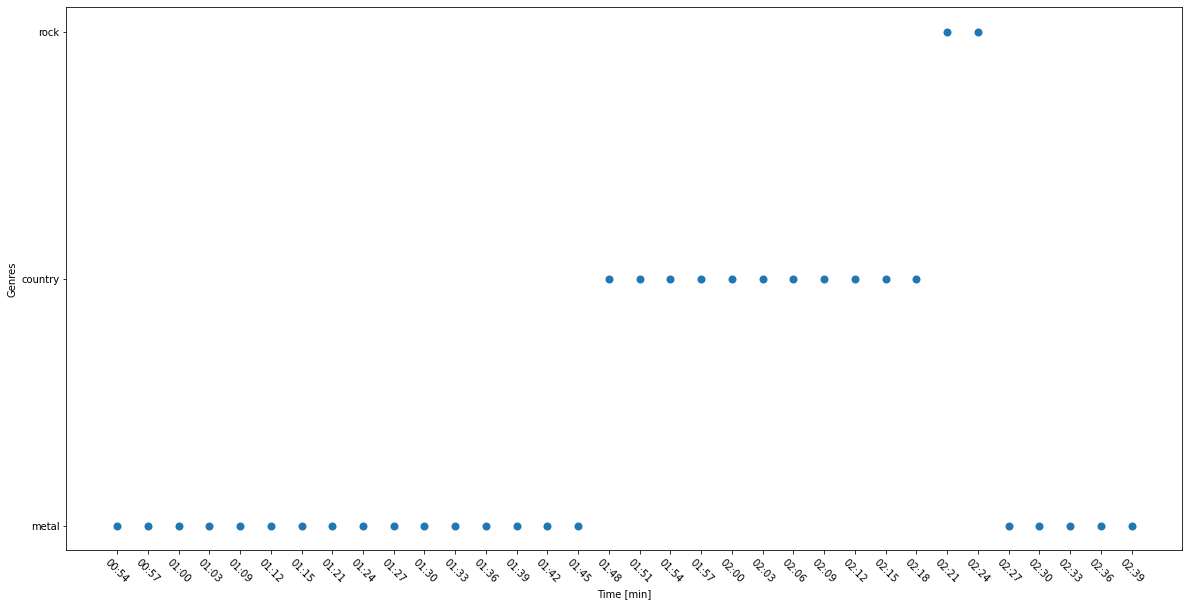

In [6]:
# Sort time and prediction
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
start = df['start'] # Get start time from dataframe

# Remove Predictions where the probability is less than then setted percentage
percentage = 0.50
i=1
list=[]
while i<len(preds):
    if proba[i][proba[i].argmax()]<percentage:
        list.append(i)
        
    i +=1
# Delete the elements and resize the list
proba=np.delete(proba,list, axis=0)
preds=np.delete(preds,list, axis=0)
start=start.drop(list)

# Plot the genres to the time series of the start times !!Attention: Plot does not show empty points!!
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
plt.xlabel("Time [min]")
plt.ylabel("Genres")
prediction_label=[]
for i in range(len(preds)):
    prediction_label.append(my_dict[preds[i]])
time = pd.to_datetime(start, unit='s').dt.strftime('%M:%S')
plt.xticks(rotation=-45)
ax.scatter(time, prediction_label, linewidth=2.0)
plt.show()

In [7]:
# Show the Probabilities of every prediction (two main classes):
preds_small = []
for i in range(len(preds)):
    print("Prediction ", i,": ", my_dict[preds[i]], " with Probabilities: ", end="")
    first = proba[i].argmax()
    temp = proba[i].copy()
    temp[first] = 0
    second = temp.argmax()
    print(round(proba[i][first]*100,1), "% (" + my_dict[first] + "), " ,round(proba[i][second]*100,1), "% (" + my_dict[second] + ")" )

Prediction  0 :  metal  with Probabilities: 96.5 % (metal),  2.2 % (rock)
Prediction  1 :  metal  with Probabilities: 52.1 % (metal),  43.1 % (rock)
Prediction  2 :  metal  with Probabilities: 91.4 % (metal),  8.0 % (rock)
Prediction  3 :  metal  with Probabilities: 86.5 % (metal),  7.8 % (disco)
Prediction  4 :  metal  with Probabilities: 59.9 % (metal),  34.8 % (country)
Prediction  5 :  metal  with Probabilities: 60.7 % (metal),  20.7 % (country)
Prediction  6 :  metal  with Probabilities: 98.9 % (metal),  0.6 % (rock)
Prediction  7 :  metal  with Probabilities: 53.7 % (metal),  28.5 % (rock)
Prediction  8 :  metal  with Probabilities: 73.3 % (metal),  12.8 % (rock)
Prediction  9 :  metal  with Probabilities: 93.9 % (metal),  5.8 % (rock)
Prediction  10 :  metal  with Probabilities: 59.7 % (metal),  27.8 % (rock)
Prediction  11 :  metal  with Probabilities: 96.8 % (metal),  2.9 % (rock)
Prediction  12 :  metal  with Probabilities: 96.5 % (metal),  1.8 % (rock)
Prediction  13 :  meta

In [8]:
# Show the Probabilities of every prediction (all classes):
print("Genres: ",genres)
for i in range(len(preds)):
    print("Prediction ", i,": ", my_dict[preds[i]], " with Probabilities: ", end="")
    for k in range(len(proba[i])):
        print(round(proba[i][k]*100,1), end="% ")
    print("")

Genres:  ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Prediction  0 :  metal  with Probabilities: 0.0% 0.0% 0.1% 0.6% 0.5% 0.0% 96.5% 0.0% 0.0% 2.2% 
Prediction  1 :  metal  with Probabilities: 0.7% 0.0% 0.3% 2.6% 0.7% 0.0% 52.1% 0.3% 0.3% 43.1% 
Prediction  2 :  metal  with Probabilities: 0.0% 0.0% 0.2% 0.2% 0.1% 0.0% 91.4% 0.0% 0.0% 8.0% 
Prediction  3 :  metal  with Probabilities: 0.4% 0.0% 2.3% 7.8% 0.2% 0.0% 86.5% 0.0% 0.1% 2.7% 
Prediction  4 :  metal  with Probabilities: 0.8% 0.0% 34.8% 2.8% 0.1% 0.0% 59.9% 0.1% 0.1% 1.4% 
Prediction  5 :  metal  with Probabilities: 1.1% 0.2% 20.7% 12.3% 0.8% 0.1% 60.7% 0.3% 0.2% 3.6% 
Prediction  6 :  metal  with Probabilities: 0.1% 0.0% 0.2% 0.2% 0.0% 0.0% 98.9% 0.0% 0.0% 0.6% 
Prediction  7 :  metal  with Probabilities: 0.4% 0.1% 1.0% 13.1% 0.1% 0.0% 53.7% 2.8% 0.3% 28.5% 
Prediction  8 :  metal  with Probabilities: 0.1% 0.0% 1.1% 4.2% 0.2% 0.0% 73.3% 8.0% 0.3% 12.8% 
Prediction  9 :  metal  w

In [9]:
# Not ready: Should be the mean of every probability in every bin (so average proba over all metal predictions)
av_proba =[]
laenge=[]
while k<10:
    av_proba[preds[k]] += proba[k][preds[k]]
    laenge[preds[k]] += 1
    k +=1
print(av_proba)    

IndexError: list index out of range

In [10]:
# Print Binned Statistics
text =""
average_proba=[]
print(repr(len(preds)) +" single predictions found. Here are the Predictions grouped by Genres:")
# Print all predictions binned on the gernes
for i in range(len(my_dict)):
    if i<len(np.bincount(preds)):
        text = text + my_dict[i] + ": " + repr(np.bincount(preds)[i]) +" (" + repr(round(np.bincount(preds)[i]/len(preds)*100,1)) +"%) \n" 
print(text)
 
 # Use the frequent value as main prediction:
prediction=my_dict[np.bincount(preds).argmax()]
print("The most predicted genre is " + prediction + " (" + repr(round(np.bincount(preds)[np.bincount(preds).argmax()]/len(preds)*100,1)) + "% of the samples)" )

34 single predictions found. Here are the Predictions grouped by Genres:
blues: 0 (0.0%) 
classical: 0 (0.0%) 
country: 11 (32.4%) 
disco: 0 (0.0%) 
hiphop: 0 (0.0%) 
jazz: 0 (0.0%) 
metal: 21 (61.8%) 
pop: 0 (0.0%) 
reggae: 0 (0.0%) 
rock: 2 (5.9%) 

The most predicted genre is metal (61.8% of the samples)
